Student ID:2933044, RNASeq Assignment Part 2

Task 3(a)

Imports all the required libraries<br>

R equivalent:
```
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)
library(bbknnR)
library(harmony)
library(monocle3)
library(slingshot)
library(SingleCellExperiment)
library(phateR)
library(grDevices)
library(RColorBrewer)
```

In [1]:
import pandas as pd
import scanpy as sc
import bbknn
import numpy as np
import anndata as ad
import scanpy.external as sce
import seaborn as sns
import matplotlib.pyplot as plt
import phate
import scprep
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

<br>
<br>
Imports the datasets and storing as a AnnData(python)/Seurat(R) object<br>
And makes the gene id unique for further analysis and filtering out low gene counts and no. of cells<br>

R equivalent: 
```
ko1.data <- Read10X(data.dir = "/data/BIOL5177/Assessment/KO1")
ko1 <- CreateSeuratObject(counts = ko1.data, project = "assignment", min.cells = 3,
min.features = 200)
wt1.data <- Read10X(data.dir = "/data/BIOL5177/Assessment/WT1")
wt1 <- CreateSeuratObject(counts = wt1.data, project = "assignment", min.cells = 3,
min.features = 200)
wt2.data <- Read10X(data.dir = "/data/BIOL5177/Assessment/WT2")
wt2 <- CreateSeuratObject(counts = wt2.data, project = "assignment", min.cells = 3,
min.features = 200)
wt3.data <- Read10X(data.dir = "/data/BIOL5177/Assessment/WT3")
wt3 <- CreateSeuratObject(counts = wt3.data, project = "assignment", min.cells = 3,
min.features = 200)
sample_list <- c(ko1, wt1, wt2, wt3)
```

In [2]:
ko1 = sc.read_10x_mtx("/data/BIOL5177/Assessment/KO1", var_names="gene_symbols", cache=True)
wt1 = sc.read_10x_mtx("/data/BIOL5177/Assessment/WT1", var_names="gene_symbols", cache=True)
wt2= sc.read_10x_mtx("/data/BIOL5177/Assessment/WT2", var_names="gene_symbols", cache=True)
wt3 = sc.read_10x_mtx("/data/BIOL5177/Assessment/WT3", var_names="gene_symbols", cache=True)

sample_list = [ko1, wt1, wt2, wt3]
for x in sample_list:
    x.var_names_make_unique() 
    sc.pp.filter_cells(x, min_genes=200) #atleast 200 genes in a cell
    sc.pp.filter_genes(x, min_cells=3) #and each gene in 3 cells

<br><br>
Adding QC stats to the objects and plotting qc plots<br>

R equivalent:<br>
```
sample.list <- lapply(sample.list, function(object) {
  object[["percent.mt"]] <- PercentageFeatureSet(object, pattern = "^MT-")
  object})
for (x in sample.list) {
    VlnPlot(x, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)
    FeatureScatter(x, feature1 = "nCount_RNA", feature2 ="percent.mt")
    FeatureScatter(x, feature1 = "nCount_RNA", feature2 ="nFeature_RNA")
    }
```

Plots for Sample 1


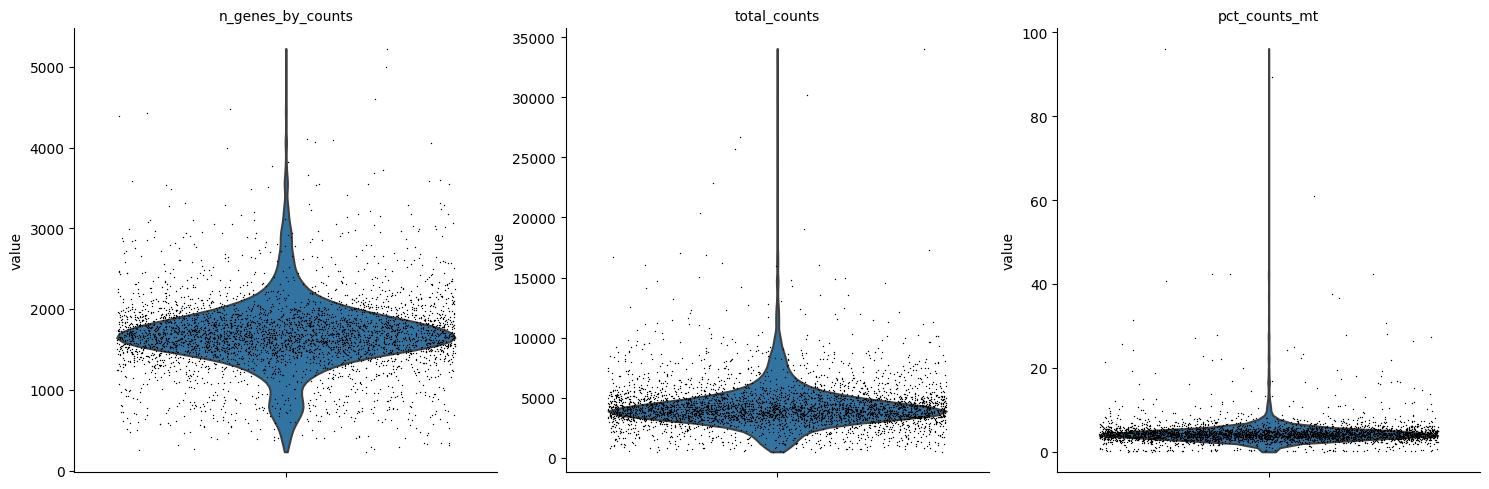

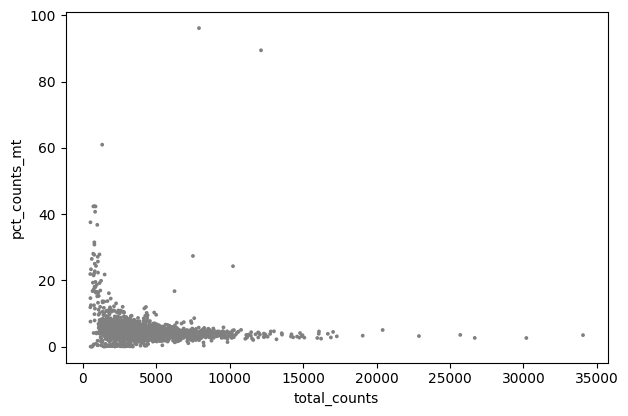

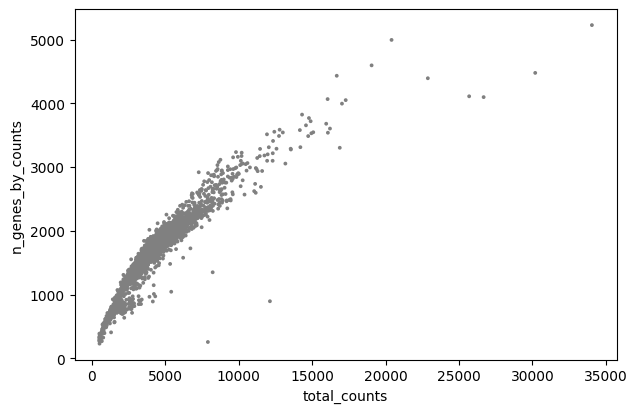

Plots for Sample 2


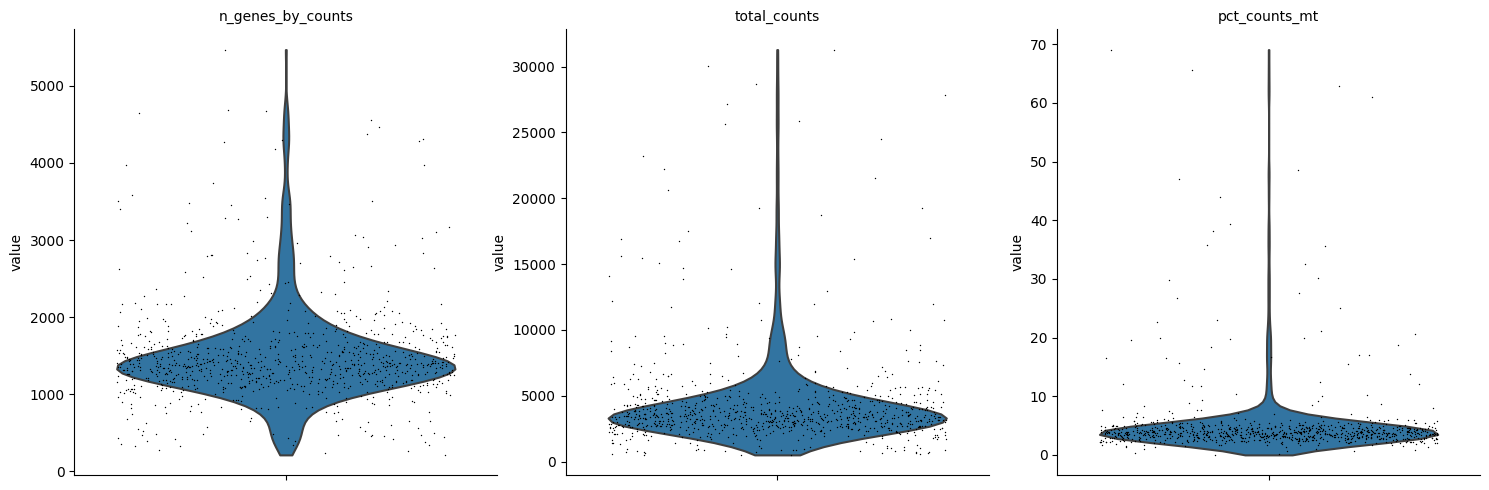

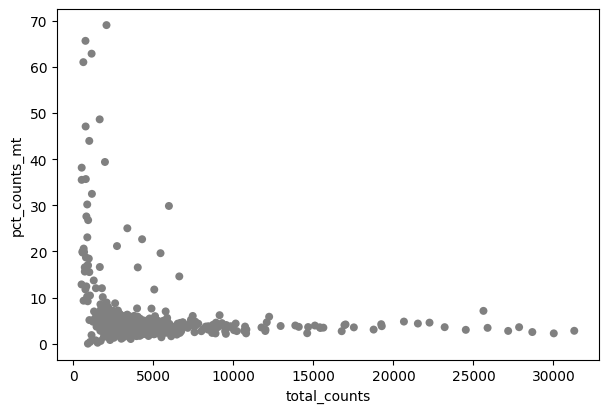

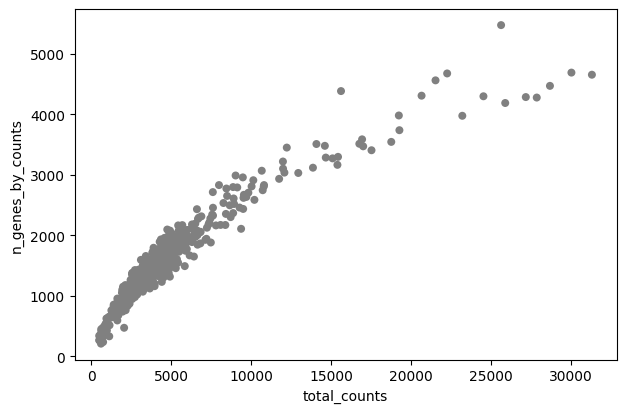

Plots for Sample 3


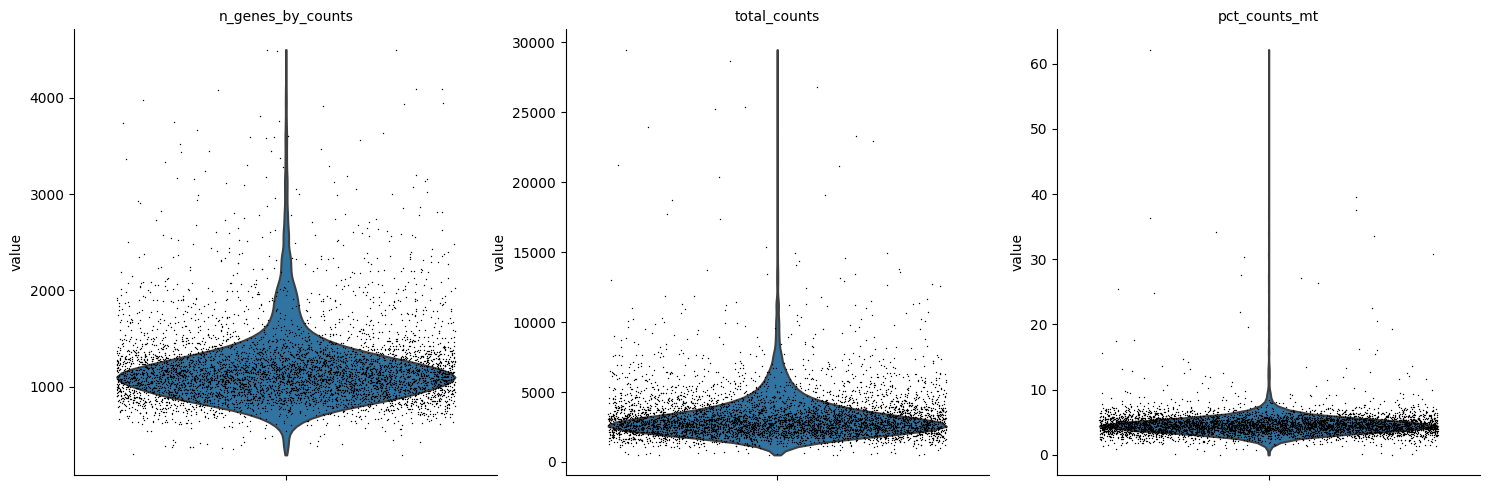

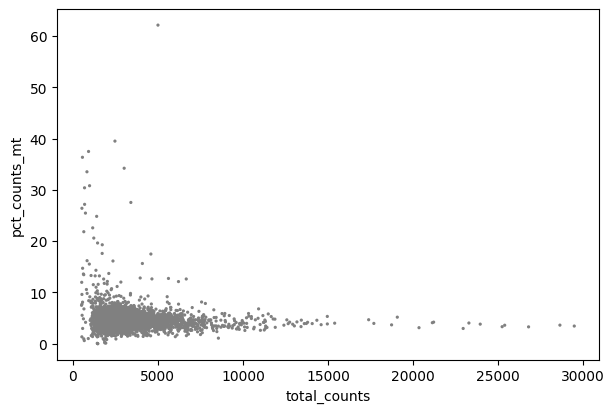

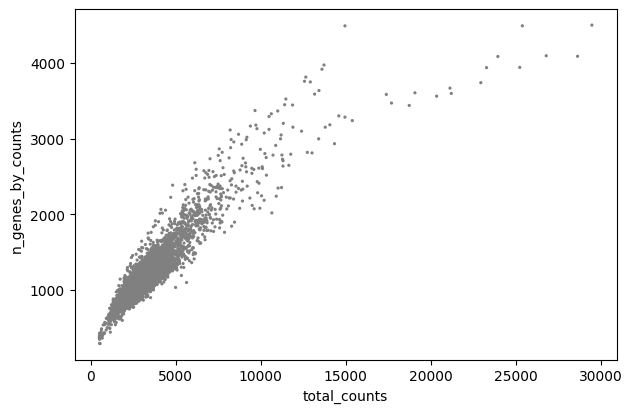

Plots for Sample 4


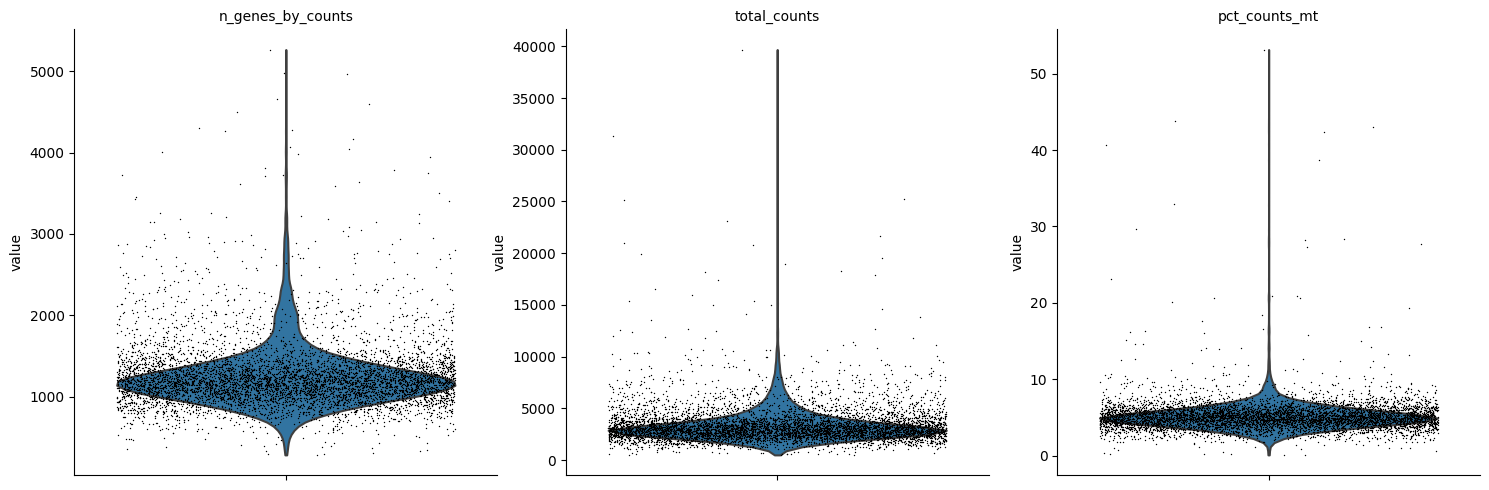

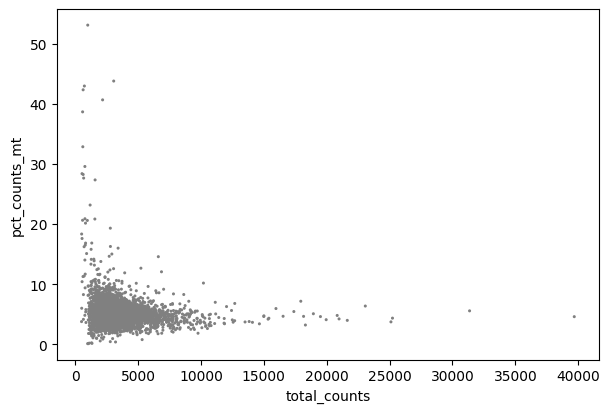

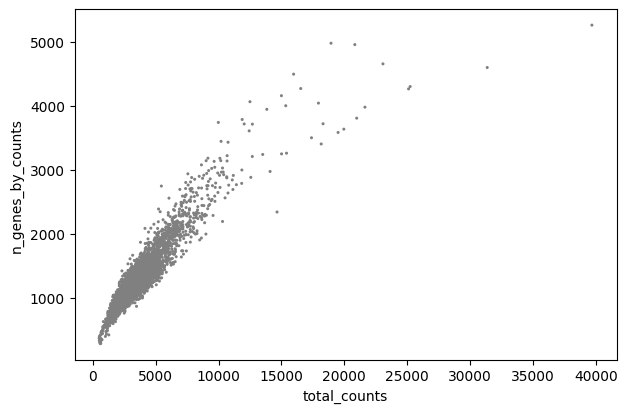

In [3]:
i = 1
for x in sample_list:
    #get the group of mitochondrial genes starting with "mt" and calculating qc
    x.var["mt"] = x.var_names.str.startswith("mt-")
    sc.pp.calculate_qc_metrics(x, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)
    
    #plotting the metrics
    print(f"Plots for Sample {i}")
    sc.pl.violin(x,["n_genes_by_counts", "total_counts", "pct_counts_mt"],jitter=0.4,multi_panel=True,)
    sc.pl.scatter(x, x="total_counts", y="pct_counts_mt")
    sc.pl.scatter(x, x="total_counts", y="n_genes_by_counts")
    i+=1

<br><br>
Filtering based on mt and total counts to remove noise, doublets and dead cells<br>

R equivalent: <br>
```
sample.list[[1]] <- subset(sample.list[[1]], 
    subset = nFeature_RNA > 200 & nFeature_RNA < 3500 & percent.mt < 9)
sample.list[[2]] <- subset(sample.list[[2]], 
    subset = nFeature_RNA > 200 & nFeature_RNA < 3500 & percent.mt < 8)
sample.list[[3]] <- subset(sample.list[[3]], 
    subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 9)
sample.list[[4]] <- subset(sample.list[[4]], 
    subset = nFeature_RNA > 200 & nFeature_RNA < 3000 & percent.mt < 10)
```

In [4]:
ko1 = ko1[(ko1.obs.n_genes_by_counts > 200) & (ko1.obs.n_genes_by_counts < 3500) & (ko1.obs.pct_counts_mt < 9)]
wt1 = wt1[(wt1.obs.n_genes_by_counts > 200) & (wt1.obs.n_genes_by_counts < 3500) & (wt1.obs.pct_counts_mt < 8)]
wt2 = wt2[(wt2.obs.n_genes_by_counts > 200) & (wt2.obs.n_genes_by_counts < 3000) & (wt2.obs.pct_counts_mt < 9)]
wt3 = wt3[(wt3.obs.n_genes_by_counts > 200) & (wt3.obs.n_genes_by_counts < 3000) & (wt3.obs.pct_counts_mt < 10)]

Using SCTranform and normalizing the data, finding the most variable genes and storing in object<br>

R equivalent:<br>
```
sample.list <- lapply(X = sample.list, FUN = function(x) {
  x <- scTransform(x)
  x <- FindVariableFeatures(x, selection.method = "vst", nfeatures = 2000)
})
```

In [5]:
for x in [ko1, wt1, wt2, wt3]:
    x.layers['raw_counts'] = x.X #saving the raw counts in layers for pseudobulk later (not needed in R)
    sc.pp.normalize_total(x) #first doing normalisation overall
    sc.pp.log1p(x)
    sc.pp.highly_variable_genes(x, min_mean=0.0125, max_mean=3, min_disp=0.5)
    #sc.pl.highly_variable_genes(x) #uncomment to see how many variable genes
    x.raw = x
    x = x[:, x.var.highly_variable]
    #this next part performs sctransform in python by removing unwanted variation
    sc.pp.regress_out(x, ["total_counts", "pct_counts_mt"]) 
    sc.pp.scale(x, max_value=10)

<br><br>
Merging all the samples into one anndata/seurat object and deleting the others from memory<br>

R equivalent: <br>
```
merged <- merge(x = sample.list[[1]],
                     y = sample.list[2:length(sample.list)],
                     merge.data = TRUE)
rm ko1, wt1, wt2, wt3
```

In [6]:
merged = ad.concat([ko1,wt1,wt2,wt3], join='outer', index_unique='_')
#adding metadata for telling which sample the data is from and what type (wt or ko) it is
merged.obs['samples'] = ['ko1'] * ko1.shape[0] + ['wt1'] * wt1.shape[0] + ['wt2'] * wt2.shape[0] + ['wt3'] * wt3.shape[0]
merged.obs['type'] = ['ko'] * ko1.shape[0] + ['wt'] * wt1.shape[0] + ['wt'] * wt2.shape[0] + ['wt'] * wt3.shape[0]
del ko1, wt1, wt2, wt3

<br><br>
Performing PCA and drawing elbow plot to determine how many components to keep<br>

R equivalent:<br>
```
merged <- RunPCA(merged, npcs = 30, verbose = FALSE)
ElbowPlot(merged)
```

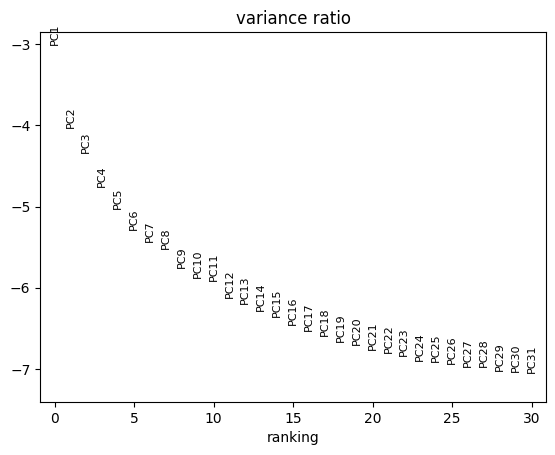

In [7]:
sc.tl.pca(merged, svd_solver="arpack")
sc.pl.pca_variance_ratio(merged, log=True) #elbow plot here

<br><br>
Finding Neighbours and Clustering & plotting UMAP before integration(decided 24 dimensions to be kept)<br>

R equivalent:<br>
```
merged <- FindNeighbors(merged, reduction = "pca", dims = 1:24)
merged <- FindClusters(merged, resolution = 0.5)
merged <- RunUMAP(merged, reduction = "pca", dims = 1:24)
DimPlot(merged)
DimPlot(merged, group.by = "orig.ident")
```

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


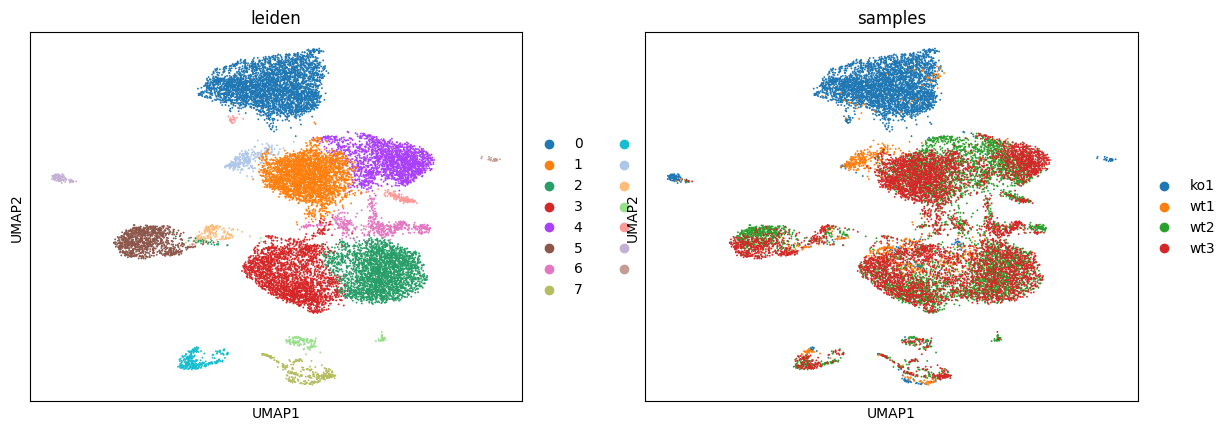

In [8]:
sc.pp.neighbors(merged, n_pcs=24)
sc.tl.umap(merged)
sc.tl.leiden(merged, resolution=0.5)  #basically findclusters from R
sc.pl.umap(merged, color=['leiden', 'samples'])#pre integration

<br><br>
Using BBKNN to integrate data<br>

R equivalent:<br>
```
sce <- as.SingleCellExperiment(merged)
sce <- bbknn(sce, batch = "samples")
merged_bbknn <- as.Seurat(sce)
```

In [9]:
merged_bbknn = merged.copy() #creating a copy to run bbknn
sce.pp.bbknn(merged_bbknn, batch_key='samples')  # running bbknn 1.3.6

Plotting UMAP after BBKNN<br>

R equivalent:<br>
```
p2 <- DimPlot(sample.bbknn, reduction = "umap", group.by = "orig.ident")
p3 <- DimPlot(sample.bbknn, reduction = "umap", label = TRUE, repel = TRUE)
p2 + p3
```

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


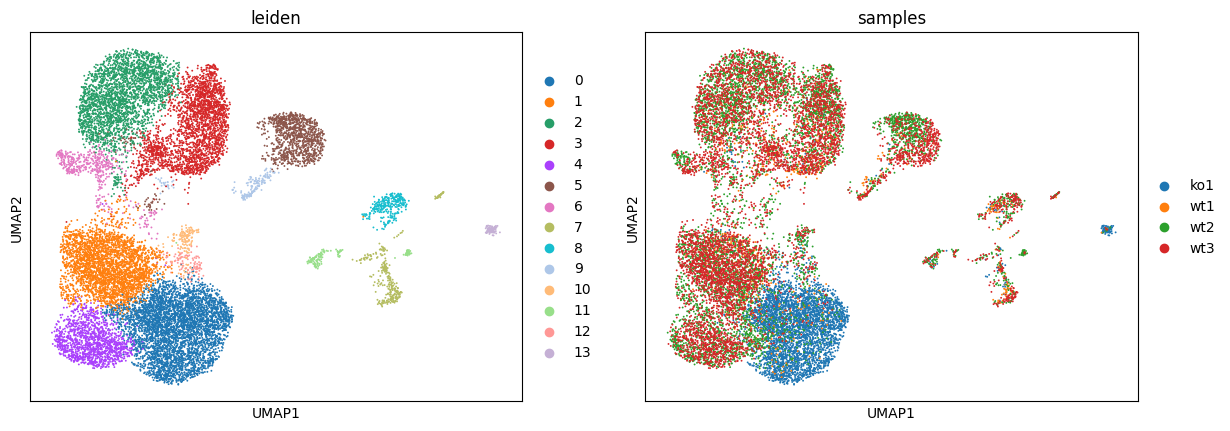

In [10]:
sc.tl.umap(merged_bbknn)
sc.tl.leiden(merged_bbknn, resolution=0.5) 
sc.pl.umap(merged_bbknn, color=['leiden', 'samples'])

<br><br>
Finding top marker genes for each cluster after BBKNN integration<br> 

R equivalent:<br>
```
DefaultAssay(sample.bbknn) <- "RNA"
sample.subset <- subset(sample.bbknn, idents = c(0,1,2))
sample.markers <- FindAllMarkers(sample.subset, only.pos = TRUE, min.pct = 0.25, 
                                logfc.threshold = 0.25, test.use = "wilcox") 
top.covid.markers <- covid.markers %>%
  group_by(cluster) %>%
  slice_max(n = 10, order_by = avg_log2FC)
```

In [11]:
sc.tl.rank_genes_groups(merged_bbknn, "leiden", method="wilcoxon")
#sc.pl.rank_genes_groups(merged_bbknn, n_genes=25, sharey=False) #dont need to plot
pd.DataFrame(merged_bbknn.uns["rank_genes_groups"]["names"]).head(5)
#5830411N06Rik aka Scart2

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,S100a10,5830411N06Rik,Ccl5,Ms4a4b,Ckb,Ccl5,AW112010,Tyrobp,Cd79a,Stmn1,Klf6,Cd9,Laptm5,Il1b
1,S100a11,Il7r,Ly6c2,Tmsb10,Ramp1,Nkg7,Nkg7,Ctss,Cd74,H2afz,Tpt1,Jun,Gm42418,Msrb1
2,Cd163l1,Rgcc,Ms4a4b,Smc4,Cxcr6,Gzma,Xcl1,Fcer1g,H2-Ab1,Hmgb2,Bcl2,Ifitm2,mt-Atp6,Tyrobp
3,S100a6,S100a4,Rpl37,Ms4a6b,Tmem176a,Klrd1,Ctsw,Lyz2,H2-Eb1,Hmgn2,Cdk6,Itm2b,mt-Co3,Cebpb
4,Crip1,Lmo4,Rpl38,Ifi27l2a,Trdc,AW112010,Ccl5,Ftl1,H2-Aa,Ptma,Ahnak,Cavin2,mt-Co2,S100a8


<br><br>
Task 3(b)

Annotating the clusters and subsetting to remove noise <br>

R equivalent:<br>
```
sample.subset <- RenameIdents(sample.bbknn, 
                             `0` = "Cd163l1+ γδ T cells", 
                             `1` = "5830411N06Rik+ γδ T cells", 
                             `2` = "Ly6c2+ γδ T cells")
DimPlot(sample.subset, label = TRUE)
sample.subset$cell.types <- Idents(covid.subset)
```

In [12]:
new_cluster_names = ["Cd163l1+ γδ T cells","5830411N06Rik+ γδ T cells","Ly6c2+ γδ T cells", '3','4','5', '6', '7', '8', '9', '10', '11','12','13']
merged_bbknn.rename_categories("leiden", new_cluster_names)
clusters_of_interest = ["Cd163l1+ γδ T cells","5830411N06Rik+ γδ T cells","Ly6c2+ γδ T cells",'3','4','5', '6', '7', '8', '9']  
#removing clusters 11-15 as all the top marker genes relate to some nk cells or bone marrow cells/ other non t cells
merged_subset_bbknn = merged_bbknn[merged_bbknn.obs['leiden'].isin(clusters_of_interest)].copy()

<br><br>
Plotting the marker genes for the three largest clusters<br>

R equivalent:<br>
```
bbknn_marker_genes <- c("Cd163l1", "5830411N06Rik", "Ly6c2")
VlnPlot(object = sample.subset, features = bbknn_marker_genes, group.by = "leiden")
```

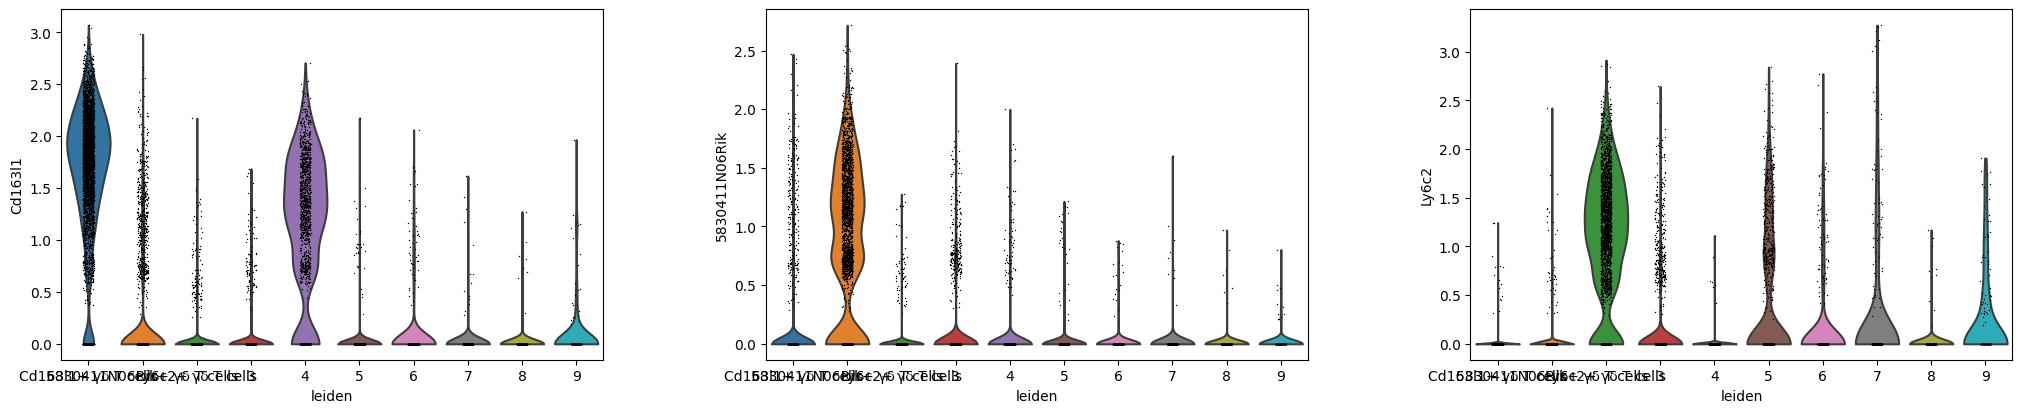

In [13]:
bbknn_marker_genes = ["Cd163l1", "5830411N06Rik", "Ly6c2"]
sc.pl.violin(merged_subset_bbknn, bbknn_marker_genes, groupby="leiden") #for comparing genes across groups

<br><br>
Plotting UMAPS and dotplot of the marker genes for the three largest clusters<br>

R equivalent:<br>
```
DimPlot(object = sample.subset, reduction = "umap", group.by = "orig.Ident", 
    cols = bbknn_marker_genes)
DotPlot(object = sce, genes.plot = bbknn_marker_genes, group.by = "orig.Ident")
```

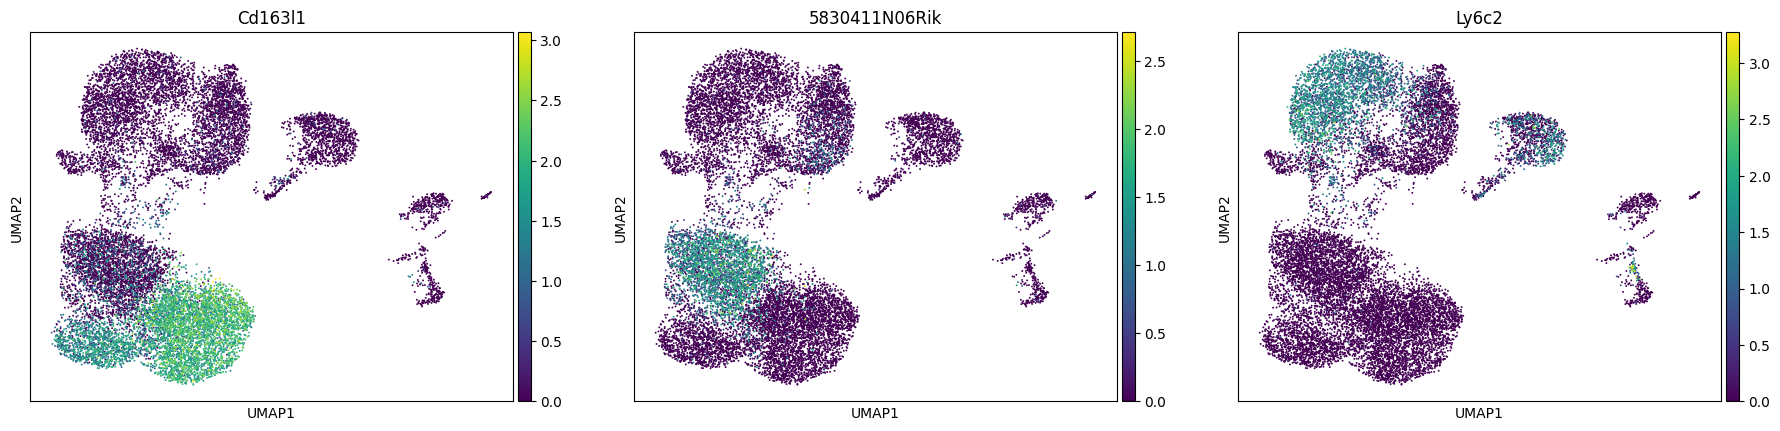

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


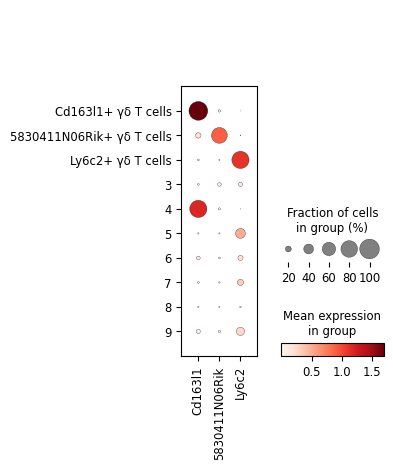

In [14]:
sc.pl.umap(merged_subset_bbknn, color=bbknn_marker_genes, use_raw=False) 
#use the raw false to actually get the corrected and scaled data
sc.pl.dotplot(merged_subset_bbknn, bbknn_marker_genes, groupby="leiden")

<br><br>
Plotting the final Annotated UMAP <br>
R equivalent: <br>
```
DimPlot(object = sample.subset, reduction = "umap", group.by = "orig.Ident",
    legend = TRUE, pt.size = 0.5, label = TRUE, label.size = 2, label.color = "black")
```

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


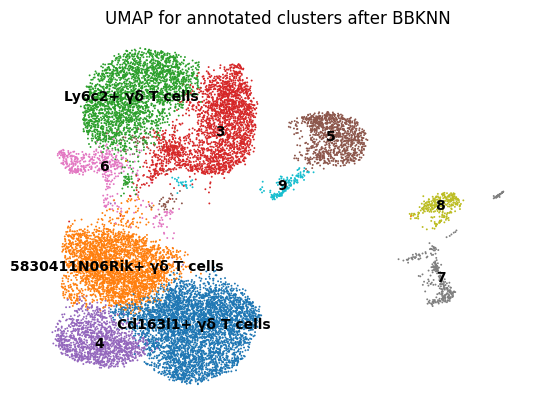

In [15]:
sc.pl.umap(merged_subset_bbknn, color="leiden", legend_loc="on data", title="UMAP for annotated clusters after BBKNN", frameon=False)

<br><br>
Task 3(c)

Plots the cell type frequency using stacked bar plots for bbknn<br>
 
R equivalent:<br>
```
freq.table.group <- as.data.frame(prop.table(x = table(Idents(sample.subset),
    sample.subset\$Status), margin = 2))
    
ggplot(data=freq.table.group, aes(x=freq.table.group$Var2, 
    y = freq.table.group$Freq, fill=freq.table.group$Var1))+  
        geom_bar(stat="identity",color="black") +
        labs(x="Group", y="Proportion of cells", fill="Cell Type") +
        scale_x_discrete(limits = rev(levels( freq.table.group$Var2)))
```

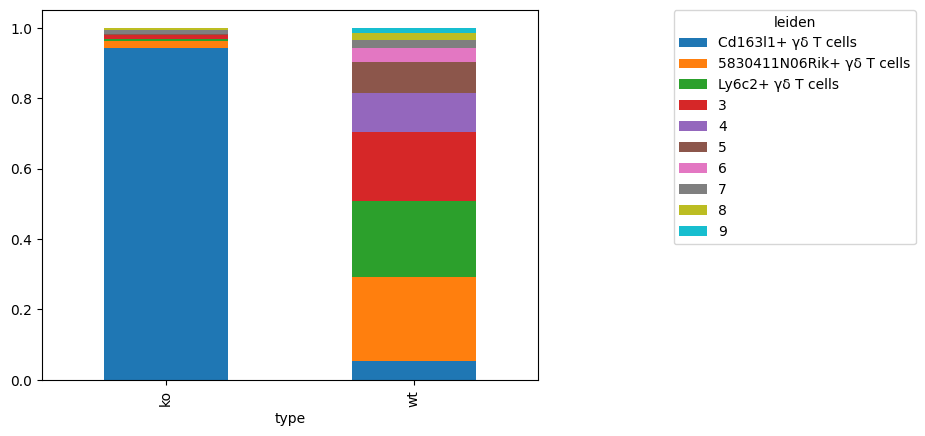

In [16]:
celltype_freq = pd.crosstab(merged_bbknn.obs['leiden'],merged_subset_bbknn.obs['type'], normalize='columns').T.plot(kind='bar', stacked=True)
celltype_freq.legend(title='leiden', bbox_to_anchor=(1.26, 1.02))

<br><br>
Task 3(d)

DE analysis for BBKNN - first taking the 0th cluster(Cd163l1+ γδ T cells) and subsetting for it <br>
then using wilcoxon test to rank the genes and finally filtering the genes for pdj and l2fc cutoffs<br>
Made a function for the de part since it can be reused for harmony de as well <br>
R equivalent:
```
sample.subset$cell.type_group <- paste(Idents(sample.subset), 
    sample.subset$Status, sep ="_")
table(sample.subset$cell.type_group)
Idents(sample.subset) <- sample.subset$cell.type_group
DefaultAssay(sample.subset) <- "RNA"
de.genes.cluster0 <- FindMarkers(sample.subset, ident.1 = "Cd163l1+ γδ T cells", 
    ident.2= "Cd163l1- γδ T cells", min.pct = 0.25, logfc.threshold = 0.25)
up.genes <- subset(de.genes.cluster0, 
    de.genes.cluster0$avg_log2FC > 0.5 & de.genes.cluster0$p_val_adj < 0.01)
up.genes <- up.genes[order(up.genes$avg_log2FC, decreasing = T),]
len(up.genes)
```

In [17]:
#Subset the AnnData object to include only cells from the relevant cluster
cluster_de_bbknn = (merged_subset_bbknn.obs['leiden'] == "Cd163l1+ γδ T cells") #using 0th (biggest) cluster
cluster_de_bbknn = merged_subset_bbknn[cluster_de_bbknn]

def de_analysis(cluster_subset):
    #Perform differential expression analysis
    sc.tl.rank_genes_groups(cluster_subset,groupby='type',method='wilcoxon')

    #Filter DE results based on adjusted p-values and log fold change thresholds
    de_df = sc.get.rank_genes_groups_df(cluster_subset, group='ko')
    filtered_de_df = de_df[(de_df['pvals_adj'] < 0.01) & (de_df['logfoldchanges'] > 0.5)]
    filtered_de_sorted = filtered_de_df.sort_values(by='logfoldchanges', ascending=False)
    return filtered_de_sorted

num_upregulated_genes_bbknn = de_analysis(cluster_de_bbknn)
print(num_upregulated_genes_bbknn.head(5))
print("Number of up-regulated genes in the KO for bbknn:", len(num_upregulated_genes_bbknn))

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


     names     scores  logfoldchanges         pvals     pvals_adj
767  Sgip1   5.671094        3.772198  1.418883e-08  2.871927e-07
272  Klrc1   9.581129        3.547074  9.598960e-22  5.506061e-20
524  Klrc2   7.083403        3.190707  1.406574e-12  4.193068e-11
140   Gzmb  12.693909        2.985499  6.391485e-37  7.003745e-35
129   Irf7  13.066116        2.719867  5.142451e-39  6.072028e-37
Number of up-regulated genes in the KO for bbknn: 1310


<br><br>
Task 3(e)

Using Harmony to integrate and doing clustering again with 24 dimensions

R equivalent:
sample.harmony<- RunHarmony(merged, group.by.vars = "orig.ident")
sample.harmony<- RunUMAP(sample.harmony, reduction = "harmony", dims = 1:24)
sample.harmony<- FindNeighbors(sample.harmony, reduction = "harmony", dims = 1:24)
sample.harmony<- FindClusters(sample.harmony, resolution = 0.5)

In [18]:
merged_harmony = merged.copy() #creating a copy to run harmony
del merged
sce.pp.harmony_integrate(merged_harmony, 'samples')
merged_harmony.obsm['X_pca'] = merged_harmony.obsm['X_pca_harmony']
sc.pp.neighbors(merged_harmony, n_neighbors=10, n_pcs=24)

2024-03-25 01:46:13,632 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-03-25 01:46:24,787 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-03-25 01:46:24,862 - harmonypy - INFO - Iteration 1 of 10
2024-03-25 01:46:28,277 - harmonypy - INFO - Iteration 2 of 10
2024-03-25 01:46:31,160 - harmonypy - INFO - Converged after 2 iterations


<br><br>
Plotting UMAP for clusters and by sample after Harmony integration <br>

R equivalent:
```
p2 <- DimPlot(sample.harmony, reduction = "umap", group.by = "orig.ident")
p3 <- DimPlot(sample.harmony, reduction = "umap", label = TRUE, repel = TRUE)
p2 + p3
```

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


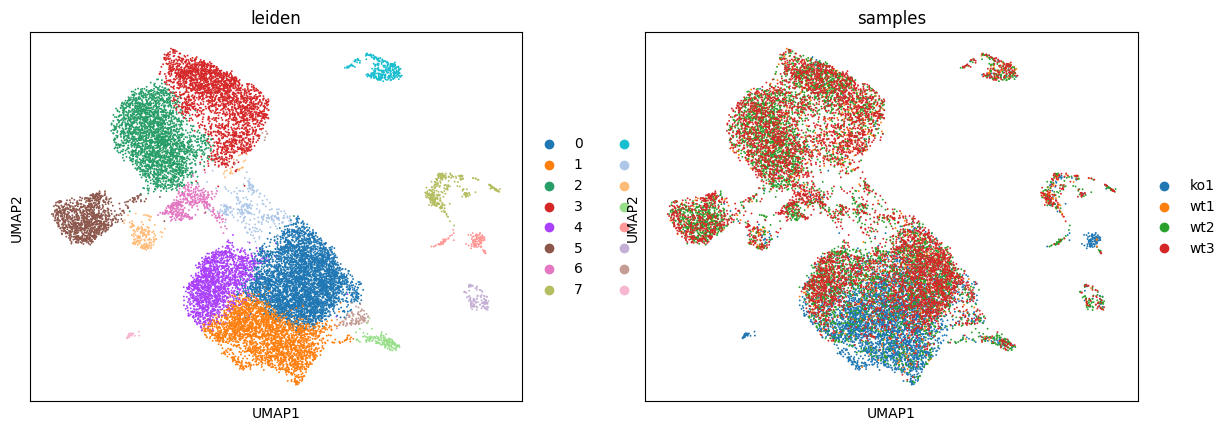

In [19]:
sc.tl.umap(merged_harmony)
sc.tl.leiden(merged_harmony, resolution=0.5) 
sc.pl.umap(merged_harmony, color=['leiden', 'samples'])

<br><br>
DE analysis for Harmony- first taking the 0th cluster and subsetting for it <br>
then using wilcoxon test to rank the genes <br>
and finally filtering the genes for pdj and l2fc cutoffs<br>

In [20]:
# Step 1: Subset the AnnData object to include only cells from the relevant cluster
cluster_de_harmony = (merged_harmony.obs['leiden'] == "0")
cluster_de_harmony = merged_harmony[cluster_de_harmony]

num_upregulated_genes_harmony = de_analysis(cluster_de_harmony) #using function defined during bbknn de
print(num_upregulated_genes_harmony.head(5))
print("Number of up-regulated genes in the KO for harmony:", len(num_upregulated_genes_harmony))

/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:580: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


           names     scores  logfoldchanges          pvals      pvals_adj
224         Clnk  13.914579        5.268649   5.166325e-44   3.523079e-42
842       Klrb1b   6.959832        5.163827   3.406788e-12   6.151187e-11
4          Trdv4  36.744354        4.926613  1.430988e-295  4.547393e-292
5     AC163354.1  36.113617        4.646993  1.386700e-285  3.147611e-282
1229       Sgip1   5.331876        4.556750   9.720348e-08   1.205672e-06
Number of up-regulated genes in the KO for harmony: 2084


<br><br>
Task 3(f) Pseudobulk function<br>
It aggregates the single-cell expression data of each sample in the subset<br>
to create pseudo-bulk samples.<br>
It thenconducts differential expression analysis between two conditions <br>
(KO and WT) using the DESeq2 package. <br>
It filters the results to retain only genes with a log2 fold change greater <br>
than 0.5 and an adjusted p-value (padj) less than 0.01. <br>
These filtered results represent genes that are significantly upregulated in<br>
the knockout (KO) condition compared to the wild type (WT) condition.<br>

R equivalent: <br>
```
pseudobulk_on_subset <- function(cell_subset) {
  pbs <- list()
  
  for (x in unique(cell_subset$obs$sample)) {
    samp_cell_subset <- cell_subset[cell_subset$obs$samples == x, ]
    samp_cell_subset$X <- raw_counts(samp_cell_subset)
    rep_adata <- AnnData(X = colSums(samp_cell_subset$X), 
        var = rownames(samp_cell_subset$X))
    rownames(rep_adata) <- x
    rep_adata$obs$type <- samp_cell_subset$obs$type[1]
    pbs[[x]] <- rep_adata
  }
  
  pb <- concat(pbs)
  counts <- as.data.frame(t(pb$X))
  
  dds <- DESeqDataSetFromMatrix(countData = counts,
                                 colData = DataFrame(pb$obs),
                                 design = ~ type)
  
  dds <- DESeq(dds)
  res <- results(dds, contrast = c("type", "ko", "wt"))
  res <- res[which(res$log2FoldChange > 0.5 & res$padj < 0.01), ]
  res <- res[order(-res$log2FoldChange), ]
  
  return(res)
}
```

In [21]:
def pseudobulk_on_subset(cell_subset):
    pbs = [] #Initialize list to store results for each sample
    
    #iterating over unique sample IDs
    for x in cell_subset.obs.samples.unique():
        #Subset cell subset for the current sample
        samp_cell_subset = cell_subset[cell_subset.obs['samples'] == x]
        #getting raw counts for the current sample from layers
        samp_cell_subset.X = samp_cell_subset.layers['raw_counts'] #make sure to use raw data
        
        #creating an AnnData object with summed counts for the current sample
        rep_adata = sc.AnnData(X = samp_cell_subset.X.sum(axis = 0), var = samp_cell_subset.var[[]])
        rep_adata.obs_names = [x] #set row names to sample ID
        rep_adata.obs['type'] = samp_cell_subset.obs['type'].iloc[0] #assign sample type from original data
        pbs.append(rep_adata) 

    pb = sc.concat(pbs) #merging all the samples again
    
    #converting pseudo-bulk counts to a data frame
    counts = pd.DataFrame(pb.X, columns = pb.var_names)
    
    #creating deseq object and running de analysis
    dds = DeseqDataSet(counts = counts, metadata = pb.obs, design_factors = 'type')
    sc.pp.filter_genes(dds, min_cells = 1) #atleast gene present in 1 cell

    dds.deseq2()
    stat_res = DeseqStats(dds, contrast = ('type', 'ko', 'wt'))
    stat_res.summary()
    de = stat_res.results_df
    
    #filtering the de by l2fc and padj 
    filtered_de = de[(de['log2FoldChange'] > 0.5) & (de['padj'] < 0.01)]
    filtered_de_sorted = filtered_de.sort_values(by='log2FoldChange', ascending=False)
    return filtered_de_sorted

<br><br>
Pseudobulk for bbknn 

R equivalent:
```
bbknn_upreg_pseudo_genes <- pseudobulk_on_subset(cluster_de_bbknn)
print(head(bbknn_upreg_pseudo_genes))
cat("Number of up-regulated genes in the KO (pseudobulk): "
    , nrow(bbknn_upreg_pseudo_genes), "\n")
```

In [22]:
bbknn_upreg_pseudo_genes = pseudobulk_on_subset(cell_subset = cluster_de_bbknn) #making the subset before passing it to the pseudobulk function
print(bbknn_upreg_pseudo_genes.head(5))
print(f"Number of up-regulated genes in the KO using bbknn(pseudobulk):{len(bbknn_upreg_pseudo_genes)}")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.38 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

/home1/bioinfo-38/.local/lib/python3.10/site-packages/pydeseq2/dds.py:442: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.02 seconds.

Fitting LFCs...
... done in 1.21 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: type ko vs wt
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik     0.071694       -0.464383  5.686416 -0.081665  0.934913   
0610009B22Rik    29.838801       -0.512926  0.626481 -0.818741  0.412934   
0610009O20Rik     8.490041        0.274605  1.154871  0.237780  0.812052   
0610010F05Rik    11.432092       -0.030050  0.984874 -0.030512  0.975659   
0610010K14Rik   101.598262       -0.192771  0.398630 -0.483584  0.628681   
...                    ...             ...       ...       ...       ...   
mt-Nd3         1282.566460       -0.598513  0.305004 -1.962312  0.049726   
mt-Nd4         4414.110232        0.121951  0.251462  0.484967  0.627700   
mt-Nd4l        1247.096175        0.210769  0.233355  0.903213  0.366413   
mt-Nd5          935.975718        0.226385  0.246990  0.916575  0.359365   
mt-Nd6          136.503320        0.051180  0.354962  0.144184  0.885355   

                   padj  
0610005C1

... done in 0.91 seconds.



<br><br>
Pseudobulk for harmony

R equivalent:
```
harmony_upreg_pseudo_genes <- pseudobulk_on_subset(cluster_de_harmony)
print(head(harmony_upreg_pseudo_genes))
cat("Number of up-regulated genes in the KO (pseudobulk): ", 
    nrow(harmony_upreg_pseudo_genes), "\n")
```

In [23]:
harmony_upreg_pseudo_genes = pseudobulk_on_subset(cell_subset = cluster_de_harmony)
print(harmony_upreg_pseudo_genes.head(5))
print(f"Number of up-regulated genes in the KO using harmony(pseudobulk):{len(harmony_upreg_pseudo_genes)}")

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 1.06 seconds.

Fitting dispersion trend curve...
... done in 0.37 seconds.

/home1/bioinfo-38/.local/lib/python3.10/site-packages/pydeseq2/dds.py:442: UserWarning: As the residual degrees of freedom is less than 3, the distribution of log dispersions is especially asymmetric and likely to be poorly estimated by the MAD.
  self.fit_dispersion_prior()
Fitting MAP dispersions...
... done in 1.26 seconds.

Fitting LFCs...
... done in 0.89 seconds.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: type ko vs wt
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
0610005C13Rik     0.566969        0.867539  3.960888  0.219026  0.826629   
0610009B22Rik    35.084659       -0.014205  0.552779 -0.025697  0.979499   
0610009O20Rik    20.531219       -0.201223  0.688416 -0.292298  0.770059   
0610010F05Rik    15.958401        0.260538  0.830464  0.313726  0.753730   
0610010K14Rik   127.226830        0.172094  0.366581  0.469457  0.638743   
...                    ...             ...       ...       ...       ...   
mt-Nd3         2540.673329       -0.708201  0.270730 -2.615897  0.008899   
mt-Nd4         8472.994727       -0.031181  0.222762 -0.139973  0.888681   
mt-Nd4l        2367.189906        0.033142  0.205091  0.161597  0.871623   
mt-Nd5         1812.799614        0.005854  0.216863  0.026992  0.978466   
mt-Nd6          230.283202        0.312472  0.277982  1.124071  0.260983   

                   padj  
0610005C1

... done in 1.16 seconds.



<br><br>
Task 4

<br>
calculating Pseudo time using paga, phate and dpt<br>
PCA is performed first and 20 dimensions were used <br>
Computes the paga for the data integrated by bbkn and plots it<br>

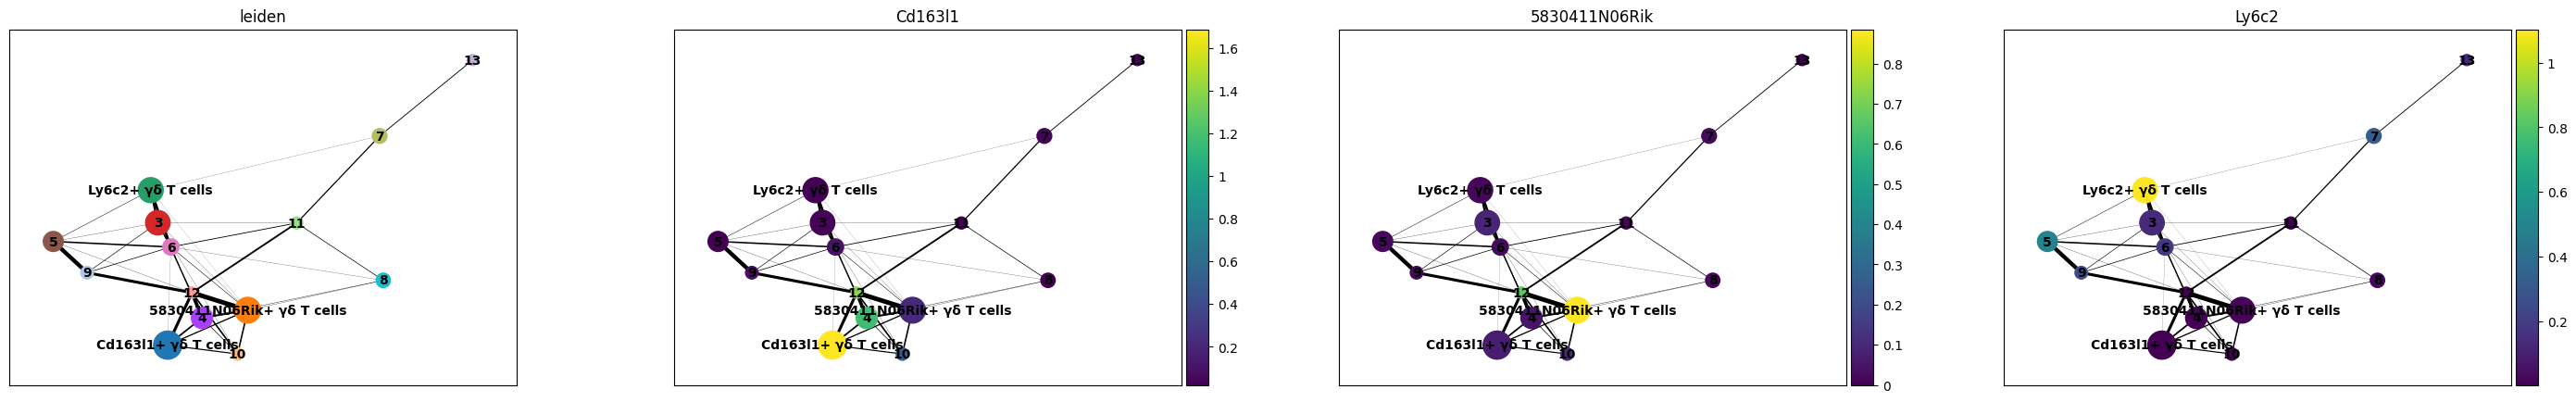

In [24]:
sc.tl.pca(merged_bbknn, svd_solver="arpack")
sc.pp.neighbors(merged_bbknn, n_neighbors=4, n_pcs=20)
sc.tl.paga(merged_bbknn, groups='leiden')
sc.pl.paga(merged_bbknn, color=["leiden", "Cd163l1", "5830411N06Rik", "Ly6c2"])
sc.tl.draw_graph(merged_bbknn, init_pos='paga')

<br><br>
Phate reduction<br>
Dimensionality reduction using phate package and plots the scatter plot to show phate<br>
R equivalent:<br>
```
phate_output <- as.matrix(phate(t(sample.subset@assays$integrated@scale.data),
    ndim=10, seed=1))
colnames(phate_output)<- paste0("PHATE_", 1:ncol(phate_output))
phate.reduction <- CreateDimReducObject(embeddings = phate_output,
    key="PHATE_",assay="integrated")
sample.subset@reductions$phate <- phate.reduction
DimPlot(sample.subset, reduction = "phate")
```

Calculating PHATE...
  Running PHATE on 16401 observations and 15889 variables.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 11.65 seconds.
    Calculating KNN search...
    Calculated KNN search in 28.79 seconds.
    Calculating affinities...
    Calculated affinities in 6.68 seconds.
  Calculated graph and diffusion operator in 47.16 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 25.11 seconds.
    Calculating KMeans...
    Calculated KMeans in 7.74 seconds.
  Calculated landmark operator in 33.83 seconds.
  Calculating optimal t...
    Automatically selected t = 16
  Calculated optimal t in 3.61 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.56 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 4.99 seconds.
Calculated PHATE in 90.17 seconds.


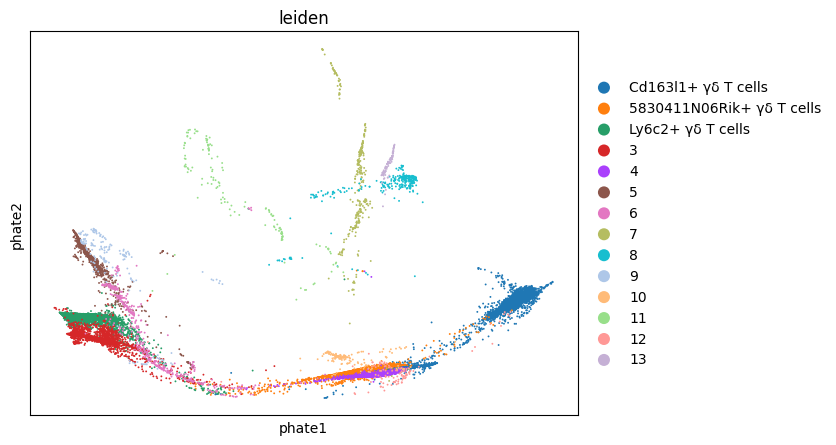

In [25]:
#Perform PHATE reduction
phate_op = phate.PHATE(n_components=2)
phate_embedding = phate_op.fit_transform(merged_bbknn.X)

#Add PHATE embedding to the AnnData object
merged_bbknn.obsm['X_phate'] = phate_embedding

#Visualize PHATE embedding
sc.pl.scatter(merged_bbknn, basis='phate', color='leiden')

<br><br>
Actually calculating and plotting pseudotime <br>
Setting the root cell to be 5830411N06Rik+ γδ T cells <br>
R equivalent in slingshot: <br>
```
pb_phate_sce <- as.SingleCellExperiment(sample.subset, assay = "RNA") 
pb_phate_sce <- slingshot(pb_phate_sce, reducedDim = 'PHATE', 
    clusterLabels = "orig.Ident", start.clus = "0")
pb_sling_phate <- SlingshotDataSet(pb_phate_sce)
gene_counts <- rowSums(pb_phate_sce@assays@data$counts)
gene_keep <- names(gene_counts)[which(gene_counts > 50)]
cells_keep <- sample(1:ncol(pb_phate_sce), (ncol(pb_phate_sce) * 0.33))
pb_sce_subset <- pb_phate_sce[gene_keep, cells_keep]
pb_sce_subset <- slingshot(pb_sce_subset, reducedDim = 'PHATE',
    clusterLabels = "orig.Ident", start.clus = "0")
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
plotcol <- colors[cut(pb_sce_subset$slingPseudotime_1, breaks=100)]
icMat <- evaluateK(counts = as.matrix(assays(pb_sce_subset)$counts),
                   sds = SlingshotDataSet(pb_sce_subset),
                   nGenes = 300,
                   k = 3:7)
pb_sce_trade <- fitGAM(counts =  pb_sce_subset@assays@data$counts, 
                       sds = SlingshotDataSet(pb_sce_subset), 
                       nknots = 6)
plotSmoothers(pb_sce_trade, assays(pb_sce_trade)$counts, 
    gene = "Il7r", alpha = 1, border = TRUE) 
```

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


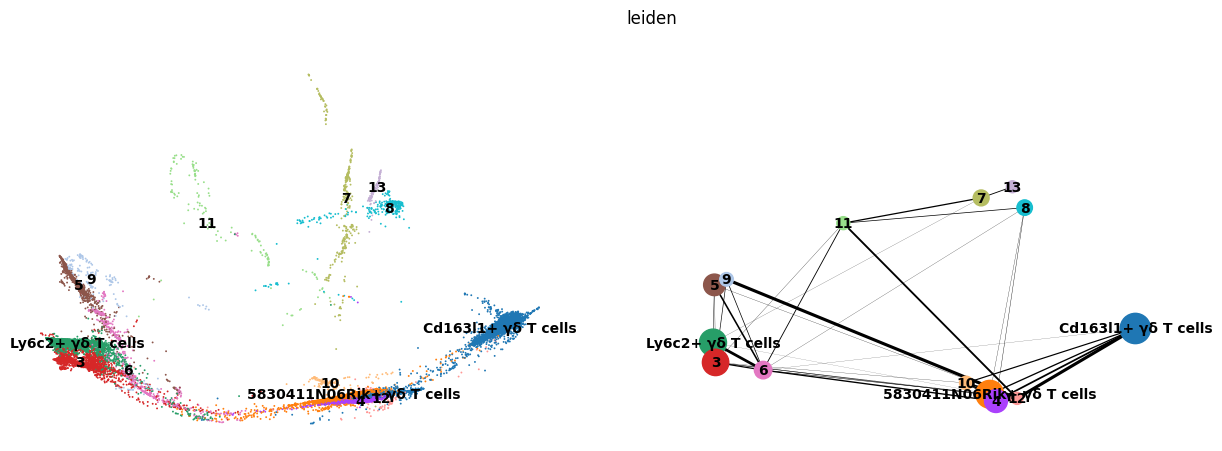

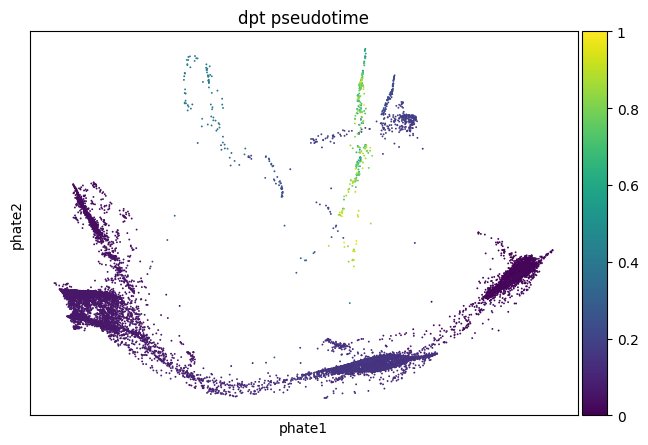

In [26]:
sc.pl.paga_compare(merged_bbknn, basis = "phate") #comparing paga path with phate
#choosing start point with iroot
merged_bbknn.uns["iroot"] = np.flatnonzero(merged_bbknn.obs["leiden"] == "5830411N06Rik+ γδ T cells")[0]
sc.tl.diffmap(merged_bbknn)
sc.tl.dpt(merged_bbknn) #this is where it actually calculates dptpseudotime
sc.pl.scatter(merged_bbknn, basis='phate', color='dpt_pseudotime')